In [1]:
import pandas as pd
import os
import sys
import numpy as np
my_path = os.path.abspath(os.path.dirname('.'))
path = os.path.join(my_path, "..")
sys.path.insert(1, path)

from extract import abstracted_trial_structurer as abst

In [2]:
wide_df=pd.read_csv("~/Downloads/md_anderson_abstracted.csv", index_col=0)

In [3]:
wide_df.head()

,Survey Identifier,Survey Timestamp,Coder Name,ClinicalTrials.gov Identifier,Please copy/paste the name of the trial here:,What cancer type (site) is eligible for this trial (choice=Acute lymphoblastic leukemia),What cancer type (site) is eligible for this trial (choice=Acute myeloid leukemia),What cancer type (site) is eligible for this trial (choice=Anal carcinoma),What cancer type (site) is eligible for this trial (choice=Basal cell skin cancer),What cancer type (site) is eligible for this trial (choice=B-Cell lymphomas),...,What is the maximum CD4 count?,Are there any other explicit inclusion criteria that were not captured above in this survey?,Please copy/paste these inclusion criteria below:,Are there any other explicit exclusion criteria that were not captured above in this survey?,Please copy/paste those exclusion criteria below:,"On a scale of 1 to 5, please rate how easy these eligibility criteria were to understand (1= very difficult, 5 = very easy)","On a scale of 1 to 5, please rate how confident you are in the accuracy of your coded information (1= not confident at all, 5= very confident)","Which aspects of these eligibility criteria were difficult to understand? Please briefly explain. If nothing was difficult, please respond: 'NA'","Please copy/paste the eligibility criteria text into a Word document and upload here, according to the directions outlined below: - Remove all headers - Remove all text not directly related to the content of the criteria (e.g. hyperlinks, references) - Please title the file as follows: 'ClinicalTrialsID_coderInitials'. For example, 'NCT03863457_MKR.doc'",Complete?
EntryID,,,,,,,,,,,,,,,,,,,,,
1,NaN,2021-06-14 10:40:30,Michael Rooney,NCT02789657,Neoadjuvant Therapy in Clinical Stage I-III HE...,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,...,NaN,Yes,It is recommended that patients have a pretrea...,Yes,"Patients with congestive heart failure, unstab...",4.0,4.0,exclusion criteria related to cardiovascular d...,NCT02789657_MKR.docx,Complete
2,NaN,2021-06-15 10:50:29,Jaime Chen,NCT04421820,BOLD-100 in Combination With FOLFOX for the Tr...,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,...,NaN,Yes,Be male or non-pregnant females who agree to c...,Yes,Neuropathy > grade 2;Previous intolerance to o...,3.0,3.0,Some medical terms/drug classes (?) I'm not fa...,NCT04421820_JC.docx,Complete
3,NaN,2021-06-15 11:15:25,Jaime Chen,NCT02979977,Dual Inhibition of EGFR With Afatinib and Cetu...,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,...,NaN,Yes,Previous treatment with a platinum-based regim...,Yes,prior exposure to any investigational EGFR or ...,3.0,3.0,therapies listed in exclusion criteria and goo...,NCT02979977_JC.docx,Complete
4,NaN,2021-06-15 11:29:28,Jaime Chen,NCT02506777,Neoadjuvant FDC With Melatonin or Metformin fo...,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,...,NaN,Yes,Expected survival >6 month Adequate liver and ...,Yes,Evidence of liver and bone marrow clinically m...,4.0,4.0,coding in the triple negative/luminal B inclus...,NCT02506777_JC.docx,Complete
5,NaN,2021-06-15 11:33:50,Dr. Fuller,NCT03224000,Trial of Magnetic Resonance Imaging Guided Rad...,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,...,NaN,Yes,Biopsy proven diagnosis of squamous cell carci...,Yes,Pregnancy,2.0,1.0,Difficulty w prior therapy,NCT03224000_CDF.doc,Complete


In [4]:
wide_df['Coder Name'].value_counts().reset_index().rename(columns={'Coder Name':'abstracted_data_point_count','index': 'coder'})

,coder,abstracted_data_point_count
0,Dr. Fuller,100
1,Clara Brotzen-Smith,72
2,Mohan Murari,71
3,Sara Youssef,70
4,Hailey Frank,70
5,Jacari Tate,70
6,Laura Minton,70
7,Jaime Chen,69
8,Andrea De Leon,69
9,Seth Chapman,34


In [5]:
abst.clean_data(wide_df)

Unique Trials Abstracted:  475
   Number of Singly-, Doubly-, and Triply- abstracted trials: 
   abstractors  trials
0            1     247
1            2     220
2            3       8


In [6]:
# Check out trials doubly abstracted by same person
# Add length field
df=wide_df

df['nct_len']=df.nct.str.len()

# Get doubly abstracted data
df_agg=df.groupby(['nct']).agg({'coder':'count'}).reset_index()
double_abs_ncts=df_agg[df_agg.coder==2].nct.to_list()
double_df=df[df.nct.isin(double_abs_ncts)].sort_values(by='nct')

# Wide to long
double_df_long=double_df.melt(id_vars=['timestamp','coder','nct'])


# Get every other row
a = np.arange(len(double_df_long))
df1 = double_df_long[(a % 2 == 1)]

# Get alternate rows
df2 = double_df_long[((a+1) % 2 == 1) ]

dff=df1.merge(df2, on=['nct','variable'])

# Measure agreement
dff['agreement']= dff['value_x'].fillna('-').eq(dff['value_y'].fillna('-'))
dff.agreement=dff.agreement.astype(int)

dff['same_coder']= dff.coder_x==dff.coder_y
dff['same_coder']=dff['same_coder'].astype(int)


# Double-reviewed by the same coder. See why they disagree with themselves.
dff_dupe=dff[dff.same_coder==1]

In [7]:
dff_dupe.nct.nunique()

3

In [8]:
dff_dupe.agreement.value_counts()

1    666
0     24
Name: agreement, dtype: int64

In [9]:
dff_dupe[dff_dupe.agreement==0].head()

,timestamp_x,coder_x,nct,variable,value_x,timestamp_y,coder_y,value_y,agreement,same_coder
13571,2021-08-26 19:41:12,Mohan Murari,NCT04005521,What cancer type (site) is eligible for this t...,Unchecked,2021-08-26 20:01:26,Mohan Murari,Checked,0,1
14011,2021-08-26 19:41:12,Mohan Murari,NCT04005521,Please type which type of cancer:,Trismus Deglutition Disorders,2021-08-26 20:01:26,Mohan Murari,Head and Neck Neoplasm Trismus Deglutition Dis...,0,1
14451,2021-08-26 19:41:12,Mohan Murari,NCT04005521,Please enter the study start date (D-M-Y): If ...,2019-06-13,2021-08-26 20:01:26,Mohan Murari,NaN,0,1
15403,2021-06-30 14:52:21,Andrea De Leon,NCT00556374,What cancer stages are allowed? Select all tha...,Checked,2021-06-15 14:24:48,Andrea De Leon,Unchecked,0,1
15623,2021-06-30 14:52:21,Andrea De Leon,NCT00556374,What cancer stages are allowed? Select all tha...,Unchecked,2021-06-15 14:24:48,Andrea De Leon,Checked,0,1


In [10]:
dff[dff.variable=='Complete?'].variable.value_counts()

Complete?    220
Name: variable, dtype: int64

In [11]:
# Concordance analysis

In [48]:
import pandas as pd
dff_clean=pd.read_csv("~/Downloads/doubly_abstracted_concordance_clean.csv", index_col=0)

In [49]:
# df.nct.nunique()

In [50]:
agreement=dff_clean.groupby(['variable']).agg({'agreement':'sum'}).reset_index()
agreement['max_agreement']=dff_clean.nct.nunique()
agreement['agreement_ratio']=agreement['agreement']/agreement['max_agreement']
agreement=agreement.sort_values(by='agreement_ratio', ascending=False)

In [51]:
agreement['var_group']=agreement['variable'].apply(lambda x: x.split(" (choice=")[0])

In [52]:
summary=agreement.groupby(['var_group']).agg({'agreement':'sum','max_agreement':'sum'}).reset_index()
summary['agreement_rate']=summary['agreement']/summary['max_agreement']
summary.sort_values(by='max_agreement', ascending=False)

,var_group,agreement,max_agreement,agreement_rate
42,Please select which biomarkers are required:,16862,16926,0.996219
49,What cancer type (site) is eligible for this t...,12999,13237,0.982020
44,Please select which substages:,2568,2604,0.986175
48,What cancer stages are allowed? Select all tha...,1137,1302,0.873272
63,Which ECOG statuses are eligible? Included all...,1264,1302,0.970814
...,...,...,...,...
28,Is there a minimum KPS specified?,214,217,0.986175
29,Is there a minimum age criterion?,215,217,0.990783
30,Is there a minimum number of brain metastases ...,199,217,0.917051
31,Is there a minimum number of metastatic sites ...,208,217,0.958525


In [53]:
summary.to_csv("~/Downloads/doubly_abstracted_concordance_summary.csv")

In [54]:
summary

,var_group,agreement,max_agreement,agreement_rate
0,Are HIV positive patients eligible?,148,217,0.682028
1,Are certain cancer biomarkers required for eli...,103,217,0.474654
2,Are certain prior cancers listed as allowable?,125,217,0.576037
3,Are only patients with a specific number of me...,177,217,0.815668
4,Are only patients with certain Eastern Coopera...,157,217,0.723502
...,...,...,...,...
62,Which AJCC edition was used?,213,217,0.981567
63,Which ECOG statuses are eligible? Included all...,1264,1302,0.970814
64,Which aspects of these eligibility criteria we...,38,217,0.175115
65,Which therapies are excluded? Please enter all...,77,217,0.354839


In [55]:
# Find agreement_thresholds with decision tree

In [56]:
import sklearn
import numpy as np

In [57]:
summary.head()

,var_group,agreement,max_agreement,agreement_rate
0,Are HIV positive patients eligible?,148,217,0.682028
1,Are certain cancer biomarkers required for eli...,103,217,0.474654
2,Are certain prior cancers listed as allowable?,125,217,0.576037
3,Are only patients with a specific number of me...,177,217,0.815668
4,Are only patients with certain Eastern Coopera...,157,217,0.723502


In [81]:
summary['rand_binary_target'] = np.random.randint(0, 2, summary.shape[0])
summary['rand_binary_feature'] = np.random.randint(0, 2, summary.shape[0])
summary.head()

,var_group,agreement,max_agreement,agreement_rate,rand_binary,rand_binary_target,rand_binary_feature
0,Are HIV positive patients eligible?,148,217,0.682028,0,0,0
1,Are certain cancer biomarkers required for eli...,103,217,0.474654,0,0,0
2,Are certain prior cancers listed as allowable?,125,217,0.576037,1,0,1
3,Are only patients with a specific number of me...,177,217,0.815668,0,1,0
4,Are only patients with certain Eastern Coopera...,157,217,0.723502,1,1,0


In [82]:
# splitting data into training and test set for independent attributes
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test =train_test_split(summary[['agreement_rate','rand_binary_feature']], summary['rand_binary_target'], test_size=.3,
                                                   random_state=42)
X_train.shape,X_test.shape

((46, 2), (21, 2))

In [83]:
#developing a model
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier(criterion = "gini", random_state = 100,
                               min_samples_leaf=10)
dtree.fit(X_train, y_train)

# https://towardsdatascience.com/how-to-tune-a-decision-tree-f03721801680

DecisionTreeClassifier(min_samples_leaf=10, random_state=100)

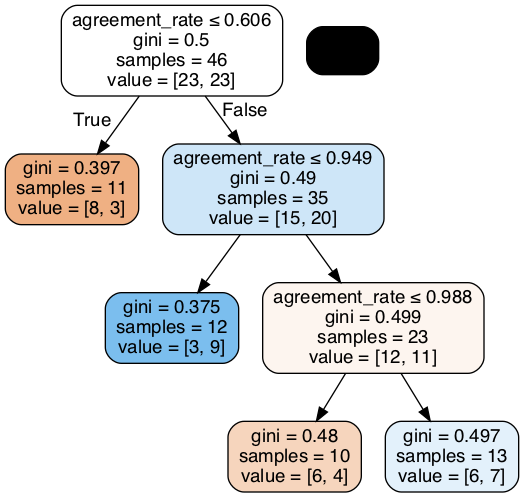

In [84]:
#visualizing the tree
import io
from io import StringIO
from sklearn.tree import export_graphviz
# from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus
import graphviz
xvar = summary[['agreement_rate','rand_binary_feature']]
feature_cols = xvar.columns
dot_data = StringIO()
export_graphviz(dtree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols)
from pydot import graph_from_dot_data
(graph, ) = graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

In [16]:
# Investigate Core Criteria

In [74]:
core_var_group=['Please select which biomarkers are required:',
                'Please select which substages:',
                'What is the maximum age?',
                'What cancer type (site) is eligible for this trial',
                'What is the minimum age?',
                'Which ECOG statuses are eligible? Included all that apply:',
                'What cancer stages are allowed? Select all that apply',
                'Are patients with metastatic cancers eligible? ',
                'Are HIV positive patients eligible?',
                'Are patients with any number of brain metastases eligible?',
                'Are patients with prior cancers eligible?',
                'How many prior lines of therapy are allowed?',
                "Which therapies are excluded? Please enter all separated by a comma (e.g. 'immunotherapy, platinum chemotherapy')"]

In [77]:
summary[summary['var_group'].isin(core_var_group)].sort_values(by='agreement_rate', ascending=False)

,var_group,agreement,max_agreement,agreement_rate
42,Please select which biomarkers are required:,16862,16926,0.996219
44,Please select which substages:,2568,2604,0.986175
52,What is the maximum age?,214,217,0.986175
49,What cancer type (site) is eligible for this t...,12999,13237,0.982020
57,What is the minimum age?,213,217,0.981567
63,Which ECOG statuses are eligible? Included all...,1264,1302,0.970814
48,What cancer stages are allowed? Select all tha...,1137,1302,0.873272
9,Are patients with metastatic cancers eligible?,156,217,0.718894
0,Are HIV positive patients eligible?,148,217,0.682028
8,Are patients with any number of brain metastas...,142,217,0.654378
